In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
%matplotlib inline

warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier,NeighborhoodComponentsAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [14]:
hcv =pd.read_csv('/Users/tokarev/Documents/programmes/DataScale/Machine Learning/Projet/Data/hcvdat0.csv')

### Remplacer les chaines de caractères par des valeurs numériques pour les rendre exploitables

In [15]:
mapping_cat = {'0=Blood Donor' : 0, '1=Hepatitis' : 1, '2=Fibrosis' : 2, '3=Cirrhosis' : 3}
mapping_sex = {'m' : 0, 'f' :1}
hcv = hcv.replace({'Category': mapping_cat})
hcv = hcv.replace({'Sex': mapping_sex})

In [16]:
hcv.isnull().sum()

Unnamed: 0     0
Category       0
Age            0
Sex            0
ALB            1
ALP           18
ALT            1
AST            0
BIL            0
CHE            0
CHOL          10
CREA           0
GGT            0
PROT           1
dtype: int64

### Remplacer valeurs NaN par la moyenne de la variable en question de la catégorie en question

In [17]:
warnings.filterwarnings('ignore')
blooddonors = hcv.loc[hcv['Category'] == 0]
hepatitis = hcv.loc[hcv['Category'] == 1]
fibrosis = hcv.loc[hcv['Category'] == 2]
cirrhosis = hcv.loc[hcv['Category'] == 3]
means_bd = []
means_hep = []
means_fib = []
means_cir = []
for i in range(4,len(hcv.columns)) :
    #print("%s : %d " % (hcv.columns[i], i-4))
    means_bd.append(hcv.loc[hcv['Category'] == 0][hcv.columns[i]].mean())
    means_hep.append(hcv.loc[hcv['Category'] == 1][hcv.columns[i]].mean())
    means_fib.append(hcv.loc[hcv['Category'] == 2][hcv.columns[i]].mean())
    means_cir.append(hcv.loc[hcv['Category'] == 3][hcv.columns[i]].mean())
    blooddonors[blooddonors.columns[i]] = blooddonors[blooddonors.columns[i]].fillna(value = means_bd[i-4])
    hepatitis[hepatitis.columns[i]] = hepatitis[hepatitis.columns[i]].fillna(value = means_hep[i-4])
    fibrosis[fibrosis.columns[i]] = fibrosis[fibrosis.columns[i]].fillna(value = means_fib[i-4])
    cirrhosis[cirrhosis.columns[i]] = cirrhosis[cirrhosis.columns[i]].fillna(value = means_cir[i-4])
frames = [blooddonors, hepatitis, fibrosis, cirrhosis]
hcv = pd.concat(frames)
hcv.isnull().sum()

Unnamed: 0    0
Category      0
Age           0
Sex           0
ALB           0
ALP           0
ALT           0
AST           0
BIL           0
CHE           0
CHOL          0
CREA          0
GGT           0
PROT          0
dtype: int64

### Création de la matrice des variables explicatives est le vecteur de la variable expliqué

In [18]:
Y = hcv.Category
X = hcv.iloc[:,2:]

### Équilibrer la taille du jeu de données pour chaque catégorie over sampling avec SMOTE

In [19]:
smote = SMOTE()
x_smote, y_smote = smote.fit_sample(X, Y)

### Création du training set et du test set

In [20]:
x_train_smote, x_test_smote, y_train_smote, y_test_smote = train_test_split(x_smote, y_smote,test_size=0.25, random_state=30, shuffle = True)

# 1- KNN

In [21]:
pipeline1 = Pipeline([('scaler', StandardScaler()),('nca', NeighborhoodComponentsAnalysis()), ('knn', KNeighborsClassifier())])

### Différents paramètres du KNN pour la grille est

In [22]:
parameteres_knn = {
    'knn__n_neighbors':[1,2,3,4,5],
    'knn__algorithm':['auto','ball_tree','kd_tree','brute'],
    'knn__leaf_size':[5,20,25,30] }

### KNN grid search

In [23]:
grid = GridSearchCV(pipeline1, param_grid = parameteres_knn, cv = 5)
grid.fit(x_train_smote, y_train_smote)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('nca',
                                        NeighborhoodComponentsAnalysis()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'knn__leaf_size': [5, 20, 25, 30],
                         'knn__n_neighbors': [1, 2, 3, 4, 5]})

In [24]:
knn_predictions = grid.predict(x_test_smote)
#Accurary Score
knn_score = accuracy_score(y_test_smote, knn_predictions)
print(knn_score)
#confusion matrix
cm = metrics.confusion_matrix(y_test_smote, knn_predictions)
print(grid.best_params_)
#Classification Report
report = metrics.classification_report(y_test_smote, knn_predictions)
print(report)

0.9924953095684803
{'knn__algorithm': 'auto', 'knn__leaf_size': 5, 'knn__n_neighbors': 2}
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       121
           1       0.99      0.99      0.99       131
           2       0.99      0.99      0.99       147
           3       1.00      1.00      1.00       134

    accuracy                           0.99       533
   macro avg       0.99      0.99      0.99       533
weighted avg       0.99      0.99      0.99       533



### Matrice de confusion KNN

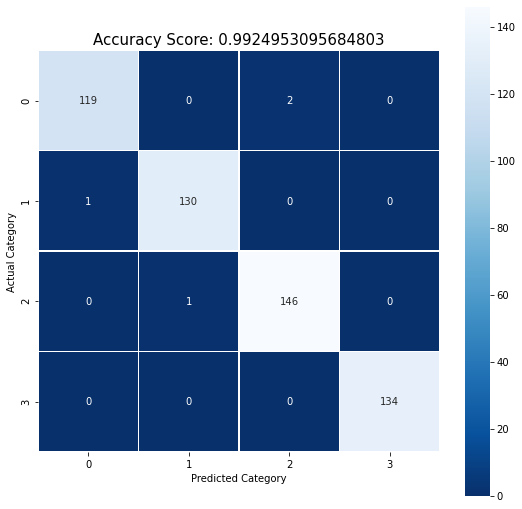

In [25]:
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Category');
plt.xlabel('Predicted Category');
all_sample_title = 'Accuracy Score: {0}'.format(knn_score)
plt.title(all_sample_title, size = 15);

# 2- SVM

In [52]:
from sklearn import svm
from sklearn.metrics import classification_report

### SVM sans cross-validation et grid search

In [55]:
SVM = svm.SVC(kernel='linear', gamma='auto', C=2)
SVM.fit(x_train_smote, y_train_smote)
svm_y_predict = SVM.predict(x_test_smote)
print(classification_report(y_test_smote, y_predict2))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       121
           1       0.85      0.83      0.84       131
           2       0.89      0.90      0.89       147
           3       1.00      1.00      1.00       134

    accuracy                           0.92       533
   macro avg       0.92      0.92      0.92       533
weighted avg       0.92      0.92      0.92       533



In [56]:
print(accuracy_score(y_test_smote, svm_y_predict))
pd.crosstab(y_test_smote, svm_y_predict)

0.9230769230769231


col_0,0,1,2,3
Category,,,,
0,117,4,0,0
1,5,109,17,0
2,0,15,132,0
3,0,0,0,134


### SVM avec cross validation

In [60]:
from sklearn.model_selection import cross_val_score
cross_SVM = svm.SVC(kernel='linear', gamma='auto', C=1)
scores = cross_val_score(cross_SVM, x_smote, y_smote, cv=5)

In [62]:
print(scores.mean())

0.9291827467537466


### SVM avec grid search et cross validation

In [63]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'linear']} 

In [64]:
from sklearn.svm import SVC 
svm_grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

In [66]:
svm_grid.fit(x_train_smote, y_train_smote) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.259, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.259, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.256, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.256, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.257, total=   0.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.916, total=   0.3s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.919, total=   0.2s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.906, total=   0.2s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.909, total=   0.2s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.925, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.625, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.591, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.578, total=   0.1s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .......... C=1, gamma=0.1, kernel=rbf, score=0.614, total=   0.1s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.916, total=   1.7s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.925, total=   0.9s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.906, total=   0.8s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .

[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.931, total=   6.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.881, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.906, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.866, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.894, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.906, total=   0.1s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.919, total=   7.0s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] .

[CV] .... C=100, gamma=0.01, kernel=linear, score=0.906, total= 1.8min
[CV] C=100, gamma=0.01, kernel=linear ................................
[CV] .... C=100, gamma=0.01, kernel=linear, score=0.900, total=  29.6s
[CV] C=100, gamma=0.01, kernel=linear ................................
[CV] .... C=100, gamma=0.01, kernel=linear, score=0.909, total= 1.0min
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.969, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.988, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.978, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=100, gamma=0.001, kernel=rbf, score=0.984, total=   0.0s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] .

[CV] .. C=1000, gamma=0.001, kernel=linear, score=0.922, total= 1.1min
[CV] C=1000, gamma=0.001, kernel=linear ..............................
[CV] .. C=1000, gamma=0.001, kernel=linear, score=0.922, total= 1.2min
[CV] C=1000, gamma=0.001, kernel=linear ..............................
[CV] .. C=1000, gamma=0.001, kernel=linear, score=0.906, total= 1.7min
[CV] C=1000, gamma=0.001, kernel=linear ..............................
[CV] .. C=1000, gamma=0.001, kernel=linear, score=0.897, total=  49.6s
[CV] C=1000, gamma=0.001, kernel=linear ..............................
[CV] .. C=1000, gamma=0.001, kernel=linear, score=0.906, total= 1.4min
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.991, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.994, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 61.5min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [67]:
print(svm_grid.best_params_) 

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


In [75]:
svm_predictions = svm_grid.predict(x_test_smote)
#Accurary Score
svm_grid_score = accuracy_score(y_test_smote, svm_predictions)
print(svm_grid_score)
#confusion matrix
cm_svm = metrics.confusion_matrix(y_test_smote, svm_predictions)
print(svm_grid.best_params_) 
#Classification Report
report = metrics.classification_report(y_test_smote, svm_predictions)
print(report)

0.9924953095684803
{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       121
           1       0.98      0.99      0.99       131
           2       0.99      1.00      0.99       147
           3       1.00      1.00      1.00       134

    accuracy                           0.99       533
   macro avg       0.99      0.99      0.99       533
weighted avg       0.99      0.99      0.99       533



### Test du SVM avec les meilleurs paramètres (obtenus avec le grid search)

In [77]:
gridcross_svm = svm.SVC(kernel='rbf', gamma=0.0001, C=1)
scores4 = cross_val_score(gridcross_svm, x_smote, y_smote, cv=5)
print(scores4.mean())

0.9676364196105596


### Matrice de confusion SVM

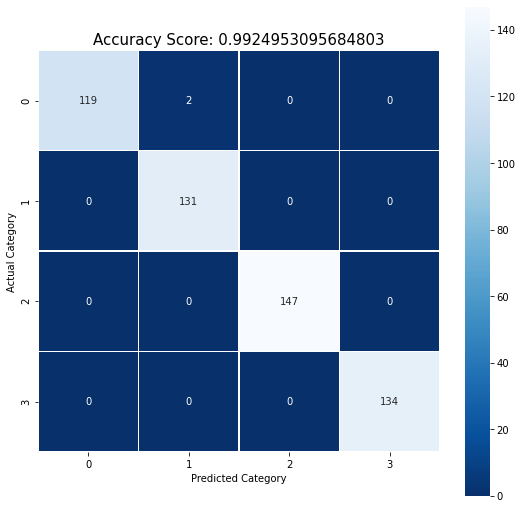

In [95]:
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Category');
plt.xlabel('Predicted Category');
all_sample_title = 'Accuracy Score: {0}'.format(svm_grid_score)
plt.title(all_sample_title, size = 15);

# 3- Regression logistique

In [78]:
from sklearn.linear_model import LogisticRegression

In [79]:
penalty = ['l1', 'l2']

In [80]:
C = np.logspace(0, 4, 10)

In [81]:
hyperparameters = dict(C=C, penalty=penalty)

In [82]:
logisticRegr = LogisticRegression(multi_class='multinomial')

In [83]:
clf = GridSearchCV(logisticRegr, hyperparameters, cv=5, verbose=0)

In [84]:
best_model = clf.fit(x_train_smote, y_train_smote)

In [85]:
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 2.7825594022071245


In [90]:
lr_predictions = best_model.predict(x_test_smote)
lr_score = accuracy_score(y_test_smote, lr_predictions)
lr_cm = metrics.confusion_matrix(y_test_smote, lr_predictions)
lr_report = metrics.classification_report(y_test_smote, lr_predictions)
print(lr_score)
print(lr_report)

0.8949343339587242
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       121
           1       0.81      0.82      0.81       131
           2       0.86      0.83      0.84       147
           3       0.99      0.98      0.98       134

    accuracy                           0.89       533
   macro avg       0.90      0.90      0.90       533
weighted avg       0.89      0.89      0.89       533



### Matrice de confusion Regression logistique

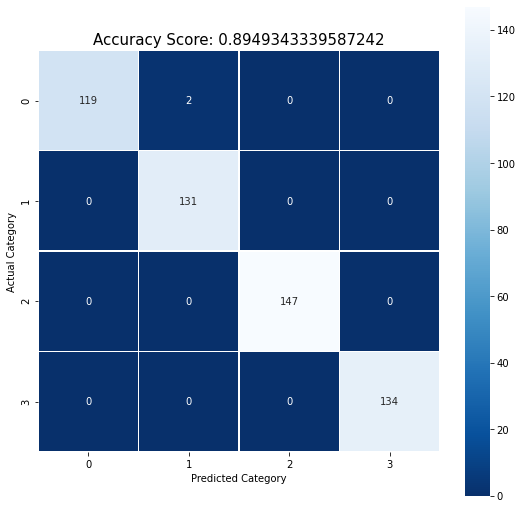

In [93]:
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual Category');
plt.xlabel('Predicted Category');
all_sample_title = 'Accuracy Score: {0}'.format(lr_score)
plt.title(all_sample_title, size = 15);